In [51]:
import pandas as pd

df = pd.read_excel("nrel_solar_benchmark_2020.xlsx",sheet_name="Figures ES-1 and ES-2",header=[1,2],index_col=0,keep_default_na=False,skiprows=lambda x:x in range(10,22))



In [74]:

data_rows = df.index

install_types = {}
# print(df.columns)
for year,id in df.columns:
    if id == 'Unnamed: 10_level_1':
        id1 = 'Utility ground mount (Fixed axis)'
    else:
        id1 = id


    if '.1' not in id:

        print(id1,year)
        if id1 not in install_types.keys():
            install_types[id1] = {}
        
        install_types[id1][year] = df[(year,id)]

Utility ground mount (Fixed axis) 2010
Utility ground mount (Fixed axis) 2011
Utility ground mount (Fixed axis) 2012
Utility ground mount (Fixed axis) 2013
Utility ground mount (Fixed axis) 2014
Utility ground mount (Fixed axis) 2015
Utility ground mount (Fixed axis) 2016
Utility ground mount (Fixed axis) 2017
Utility ground mount (Fixed axis) 2018
Utility ground mount (Fixed axis) 2019
Utility ground mount (Fixed axis) 2020
Utility ground mount (one-axis tracker) 2010
Utility ground mount (one-axis tracker) 2011
Utility ground mount (one-axis tracker) 2012
Utility ground mount (one-axis tracker) 2013
Utility ground mount (one-axis tracker) 2014
Utility ground mount (one-axis tracker) 2015
Utility ground mount (one-axis tracker) 2016
Utility ground mount (one-axis tracker) 2017
Utility ground mount (one-axis tracker) 2018
Utility ground mount (one-axis tracker) 2019
Utility ground mount (one-axis tracker) 2020
Commercial Rooftop 2010
Commercial Rooftop 2011
Commercial Rooftop 2012
Comm

In [95]:
import numpy as np

data_series = {}
y0 = np.inf
for id,val in install_types.items():
    data_series[id] = {'year':[]}
    for r in data_rows:
        data_series[id][r] = []
    for y,dat in val.items():
        y0 = min(y,y0)
        data_series[id]['year'].append(y)
        for r in dat.index:
            d = dat[r]
            if dat[r] == '':
                d = 0.0
            data_series[id][r].append(d)


    

In [105]:

def offset_exp(x,a,b,c):
    return a*np.exp(-b*(x-y0))+c

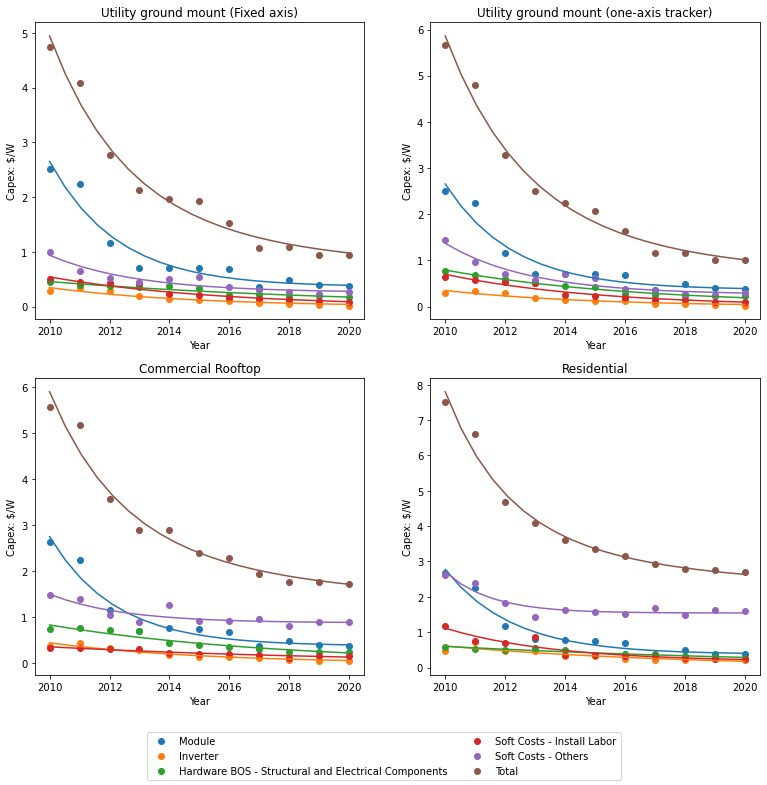

In [137]:
import scipy.optimize as opt
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(13,12))
i = 1
for id,data in data_series.items():
    fig.add_subplot(2,2,i)
    npp = 20
    tot = np.zeros(npp)
    data_series[id]['cf'] = {}
    for r in data_rows[:-2]:
        xs = np.array(data['year'])
        ys = np.array(data[r])
        if r == data_rows[-3]:
            ys += np.array(data[data_rows[-2]])
        plt.scatter(xs,ys,label=r.split('(')[0])

        popt,pcov = opt.curve_fit(offset_exp,xs,ys,p0=[(ys[0]-ys[-1]),0.001,np.min(ys)],bounds=(0,np.inf))

        data_series[id]['cf'][r] = popt

        xs2 = np.linspace(xs[0],xs[-1],npp)
        ys2 = offset_exp(xs2,*popt)
        tot += ys2
        plt.plot(xs2,ys2)

    plt.plot(xs2,tot)
    plt.scatter(xs,data[data_rows[-1]],label='Total')
    plt.title(id)
    plt.xlabel('Year')
    plt.ylabel('Capex: $/W')
    i+=1

ax = plt.gca()
handles,labels = ax.get_legend_handles_labels()
fig.legend(handles,labels,ncol=2,loc='lower center')
plt.savefig('nrel_costs_and_fits.png',facecolor='white')

0.6317766633825774
0.6646937155689665
1.2714583241196686
2.118324369654456


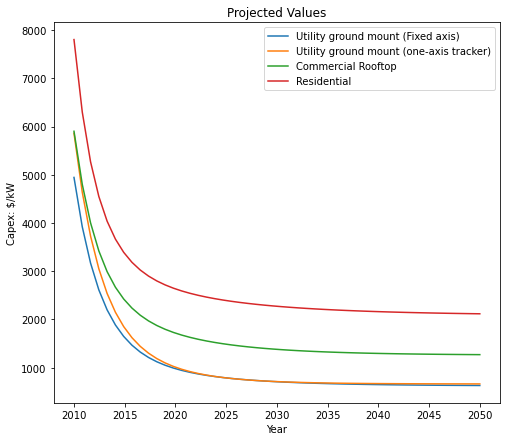

In [139]:
y1 = 2050
plt.figure(figsize=(8,7))
for id,data in data_series.items():
    fits = data['cf']
    npp = 50
    xs = np.linspace(y0,y1,npp)
    tot = np.zeros(npp)
    for r,f in fits.items():
        tot += offset_exp(xs,*f)
    plt.plot(xs,tot*1000,label=id)
    print(tot[-1])
plt.title('Projected Values')
plt.xlabel('Year')
plt.ylabel('Capex: $/kW')
plt.legend()
plt.savefig('Projected Solar Capex')